In [1]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from imutils.paths import list_images

import imgaug as ia
import imgaug.augmenters as iaa

In [45]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.7, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.7), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((4, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((1.5, 2.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-8, 8),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

/Users/acidlabs/miniconda3/envs/ai-pulenta/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/Users/acidlabs/miniconda3/envs/ai-pulenta/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [46]:
# objectivo:
# definir un datagenerator que reciba un directorio y genere un batch de imagenes
# adicionalmente, debe retornar el tipo de pokemon
# la informacion del tipo de pokemon debe ser leida desde el arhcivo pokemonDB_dataset.json

In [47]:
db_dir = "../data/Pokemon Images DB"
json_dir = "../data/pokemonDB_dataset.json"

# read images list files
images_list = list(list_images(db_dir))

# filter list of images. Use that hasn't "_new" in the name
images_list = [i for i in images_list if "_new" not in i]

In [48]:
images_list[:5]

['../data/Pokemon Images DB/Pokemon Images DB/Mandibuzz/Mandibuzz.png',
 '../data/Pokemon Images DB/Pokemon Images DB/Hisuian Voltorb/Hisuian Voltorb.png',
 '../data/Pokemon Images DB/Pokemon Images DB/Corviknight/Corviknight.png',
 '../data/Pokemon Images DB/Pokemon Images DB/Hisuian Typhlosion/Hisuian Typhlosion.png',
 '../data/Pokemon Images DB/Pokemon Images DB/Dolliv/Dolliv.png']

In [49]:
# funcion con return es una funcion
# funcion con yield es un generador

# un generador es iterador que va generando los datos in situ y solo cuando los necesita

def get_generator(images_list, json_dir, batch_size=4, image_size=(224, 224), augmentate=False):
    # read json information
    with open(json_dir, "r") as json_file:
        json_data = json.load(json_file)
    
    # print(json_data.keys())
    # pokemon_type = json_data[pokemon_name]

    batch_images = list()
    batch_types = list()
    batch_names = list()

    # iterate over images list and retrieve some data
    for image_path in images_list:
        if len(batch_images) < batch_size:
            # read image and change color space to RGB
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if augmentate:
                image = seq.augment_image(image)
            image_normalized = image / image.max()

            # augmentate image
            
            # get pokemon name and type
            pokemon_name, file_extension = os.path.basename(image_path).split(".") # str
            pokemon_type = json_data[pokemon_name].get("Type") # str

            # resize image
            image_normalized = cv2.resize(image_normalized, image_size)

            # append to batch list
            # batch_list.append((image, pokemon_name, pokemon_type))

            batch_images.append(image_normalized)
            batch_types.append(pokemon_type)
            batch_names.append(pokemon_name)
        
        elif len(batch_images) == batch_size:
            yield batch_images, batch_names, batch_types
            
            # reset batch list
            batch_images = list()
            batch_types = list()
            batch_names = list()

In [50]:
# generator = [
#     batch_1 = (image, pokemon_name, pokemon_type),
#     batch_2 = (image, pokemon_name, pokemon_type),
# ]

In [51]:
# generator_2 = [
#     batch_1 = (
#         list(images),
#         list(pokemon_type)
#     ),

#     batch_2 = (
#         list(images),
#         list(pokemon_type)
#     )
# ]

In [52]:
images_list[0]

'../data/Pokemon Images DB/Pokemon Images DB/Mandibuzz/Mandibuzz.png'

In [53]:
image = cv2.imread(images_list[0])
image = seq.augment_image(image)

0 4 4 4


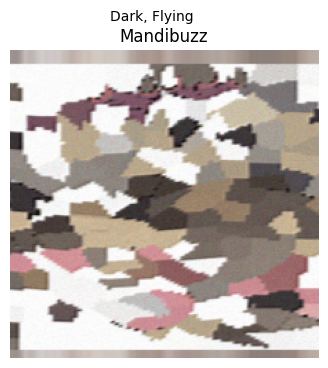

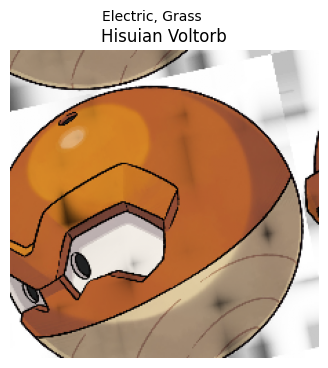

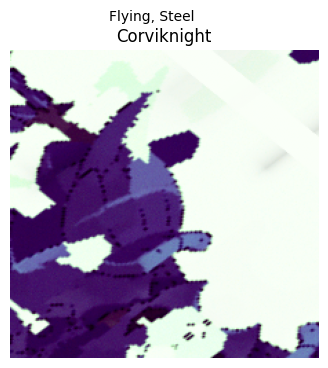

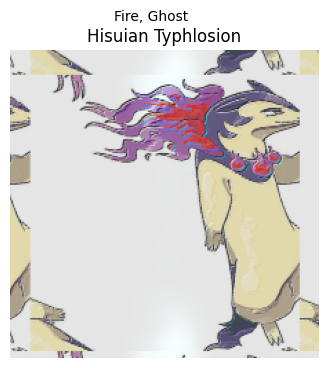

In [54]:
datagenerator = get_generator(
    images_list=images_list,
    json_dir=json_dir,
    batch_size=4,
    image_size=(224, 224),
    augmentate=True
)

# iterate over generator
for i, (images_batch, pokemon_names_batch, pokemon_types_batch) in enumerate(datagenerator):
    # print information about the batch
    print(i, len(images_batch), len(pokemon_names_batch), len(pokemon_types_batch))

    # iterate over batches
    for batch in zip(images_batch, pokemon_names_batch, pokemon_types_batch):
        image, pokemon_name, pokemon_type = batch
        # create figure
        figure = plt.figure(figsize = (10, 4))
        # add title (name of pokemon)
        plt.title(pokemon_name)

        # add subtitle (type of pokemon)
        plt.suptitle(pokemon_type, fontsize=10)

        # show image
        plt.imshow(image)
        plt.axis("off")
        plt.show()

    break

In [30]:
# help(np.uint8)

# int -35000, 128000

# # acotando la parte negativa
# uint -> unisgned # no soporta valores menores que cero
# 0, 128.000
# 8 -> 8 bits -> 8*8 = 256 -> 0-255 -> rango de valores para imagenes rgb

In [31]:
# images content
image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [32]:
image.min(), image.max()

(0, 255)

In [38]:
image.mean()

221.68551365858843

In [33]:
np.median(image)

255.0

In [34]:
# normalize image values
# image_normalized = image / image.max()
image_normalized = image / 255.0

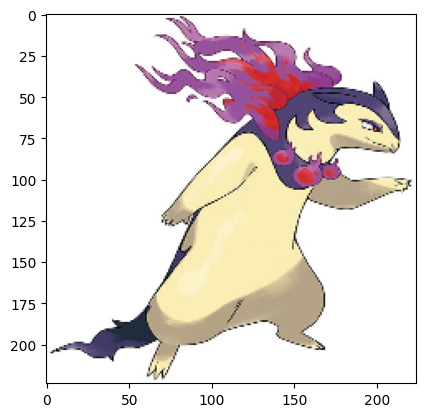

In [35]:
plt.imshow(image_normalized)
plt.show()

In [37]:
image_normalized.min(), image_normalized.max()

(0.0, 1.0)

In [39]:
image_normalized.mean()

0.869354955523876